# Markov chain construction

Caveats (at least for the time being)
- Only standard tuning.
- Only one key.
- No duration included in each note (no time signature either). TO BE CHANGED
- No silences included. TO BE CHANGED
- No memory: the probability just depends on the note where you are, not the ones where you were. TO BE CHANGED TO 1 OR 2 MEMORY
- More than a note played at the same time are considered 

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import guitarpro as gp
import copy

from custom_functions import string_to_letter, letter_to_string

## Standard Markovian (memory-less)

In [5]:
song = gp.parse("Ginpatsu_no_shounen_Killua.gp5", encoding='UTF-8')

In [6]:
def construct_chain(song, silence=True, track=None):
    '''
    From a guitarpro parsed file, build its corresponding
    Markov chain as a network with normalized out-degrees.
    '''
    G = nx.DiGraph()
    
    key = None
    frac = None

    # Get notes on the graph, and the edges between them, with weights
    for track in song.tracks:

        print(track.name)

        for measure in track.measures:

            if measure.keySignature.name != key:
                key = measure.keySignature.name
                print('Measure key:', key)

            if str(measure.timeSignature.numerator) + "/" + str(measure.timeSignature.denominator.value) != frac:
                frac = str(measure.timeSignature.numerator) + "/" + str(measure.timeSignature.denominator.value)
                print('Measure time signature:', frac)

            for voice in measure.voices[:-1]: # there is an extra, empty voice to remove at the end

                for beat in voice.beats:
                    
                    #print(beat)

                    if silence and len(beat.notes) == 0:
                        #### Later we will need to deal with this, including it.
                        continue
                    
                    #print('past silence')

                    for i, note in enumerate(beat.notes):
                        
                        #print(i, note.value)
                        if i == 0:
                            node = str(note.value) + string_to_letter(note.string)
                        else:
                            node += '-' + str(note.value) + string_to_letter(note.string)
                        
                    G.add_node(node)

                    if 'prev_node' in locals():

                        edge = (prev_node, node)

                        if (prev_node, node) in G.edges:
                            G.edges[edge[0], edge[1]]['weight'] += 1
                        else:
                            G.add_edge(*edge, weight=1)

                    prev_node = node

    G.key = key
    G.frac = frac
    
    # Normalize the out-edge weights
    for node, degree in dict(G.out_degree()).items():
        
        sum_weights = np.sum([G.edges[edge[0], edge[1]]['weight'] for edge in G.out_edges(node)])
        
        for edge in G.out_edges(node):
            G.edges[edge[0], edge[1]]['weight'] /= sum_weights
    
    return G

Traccia 1
Measure key: CMajor
Measure time signature: 3/4


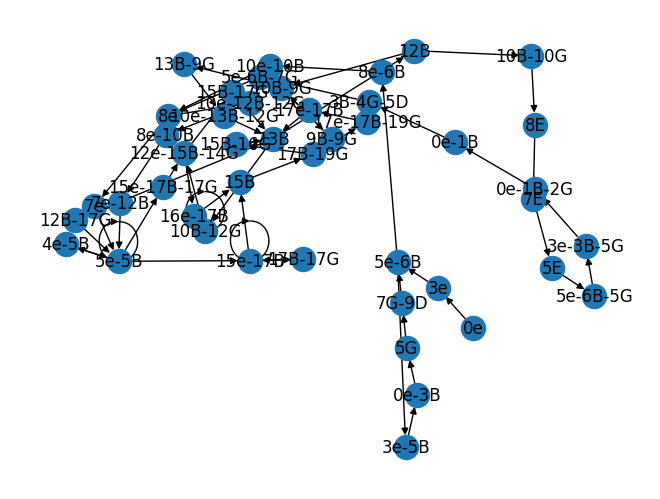

In [7]:
G = construct_chain(song)
nx.draw(G, with_labels = True)

## With memory of the previous state

Failed attempts:
- LineGraph. Does not work, because the creation of the linegraph creates spurious connections between edges, not pertaining to the data.
- Cartesian product of original nodes as the node in the new graph (n_i,n_j). Does not work because it can't then point to a single node, but rather to another "compound" one.
- Memory graph. A graph M containing every other connection (e.g. if in the original data we have A->B->C->D, in the memory graph we would have A->C and B->D). Then at each step we would check possible edges in the memory graph from the previously visited node to the next nodes.

Current (best) attempt: taking the idea of the linegraph, but keeping just the subgraph corresponding to the connections in the data. That is, if we have A->B->C->D, then we construct AB->BC->CD, in essence joining pairs sharing the start/end, IFF that path has ever been traveled in the data. 

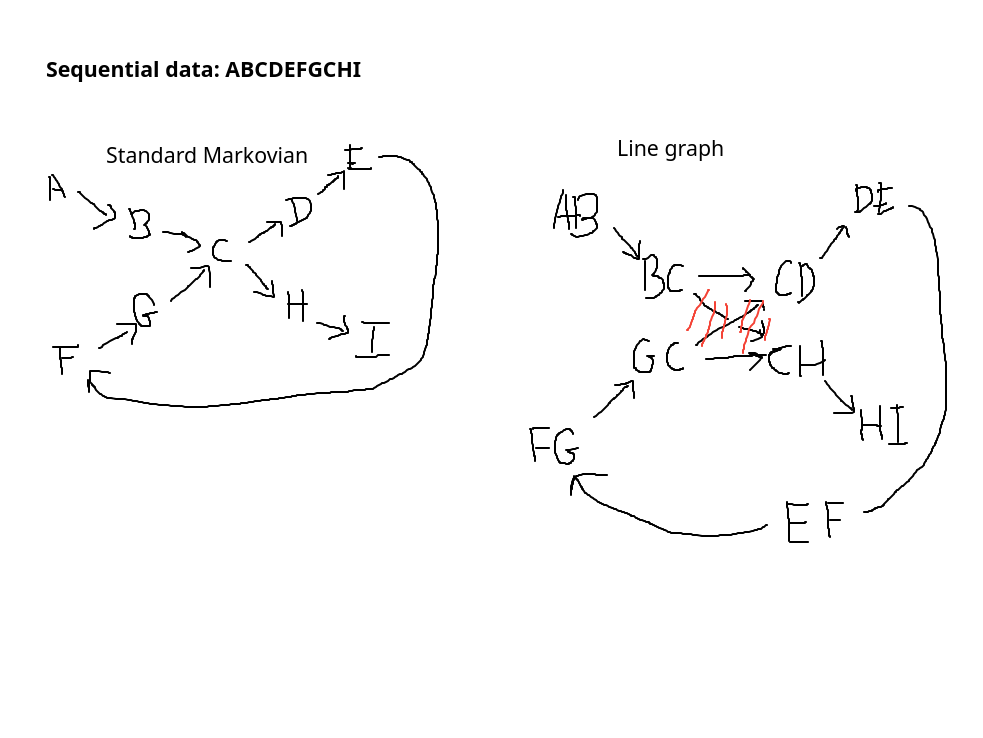

In [8]:
def get_nodes(song, silence=True, track=None):
    '''
    Get the ordered list of nodes (which can be repeated) 
    involved in the song
    '''
    
    nodelist = []
    
    key = None
    frac = None

    # Get notes on the graph, and the edges between them, with weights
    for track in song.tracks:

        print(track.name)

        for measure in track.measures:

            if measure.keySignature.name != key:
                key = measure.keySignature.name
                print('Measure key:', key)

            if str(measure.timeSignature.numerator) + "/" + str(measure.timeSignature.denominator.value) != frac:
                frac = str(measure.timeSignature.numerator) + "/" + str(measure.timeSignature.denominator.value)
                print('Measure time signature:', frac)

            for voice in measure.voices[:-1]: # there is an extra, empty voice to remove at the end

                for beat in voice.beats:
                    
                    #print(beat)

                    if silence and len(beat.notes) == 0:
                        #### Later we will need to deal with this, including it.
                        nodelist.append('')
                        continue
                    
                    #print('past silence')

                    for i, note in enumerate(beat.notes):
                        
                        #print(i, note.value)
                        if i == 0:
                            node = str(note.value) + string_to_letter(note.string)
                        else:
                            node += '-' + str(note.value) + string_to_letter(note.string)
                        
                    nodelist.append(node)
    
    return nodelist, key, frac

In [9]:
nodelist, key, frac = get_nodes(song)

Traccia 1
Measure key: CMajor
Measure time signature: 3/4


In [10]:
nodelist[:6]

['', '0e', '3e', '5e-6B', '3e-5B', '0e-3B']

In [11]:
def line_datagraph(song, silence=True, track=None):
    '''
    Construct the subgraph of the linegraph of the Markov chain, 
    dictated by the existence of the connections between edges in the data.
    '''
    
    LdG = nx.DiGraph()
    
    # Populate the graph without silences
    nodelist, key, frac = get_nodes(song)
    LdG.key = key
    LdG.frac = frac
    
    # Create the nodes of the Linegraph, i.e. the edges of the graph.
    edgelist = []
    for nodei, nodef in zip(nodelist[:-1],nodelist[1:]):
        if nodei and nodef:
            edgelist.append(nodei + 'x' + nodef)
    
    # Connect the contiguous edges from the data
    for i, edge in enumerate(edgelist[:-1]):
        if (edge, edgelist[i+1]) in LdG.edges:
            LdG.edges[edge, edgelist[i+1]]['weight'] += 1
        else:
            LdG.add_edge(edge, edgelist[i+1], weight=1)

    # Normalize the out-edge weights
    for node, degree in dict(LdG.out_degree()).items():
        
        sum_weights = np.sum([LdG.edges[edge[0], edge[1]]['weight'] for edge in LdG.out_edges(node)])
        
        for edge in LdG.out_edges(node):
            LdG.edges[edge[0], edge[1]]['weight'] /= sum_weights
            
    return LdG
    

In [13]:
LdG = line_datagraph(song, silence=True, track=None)

Traccia 1
Measure key: CMajor
Measure time signature: 3/4


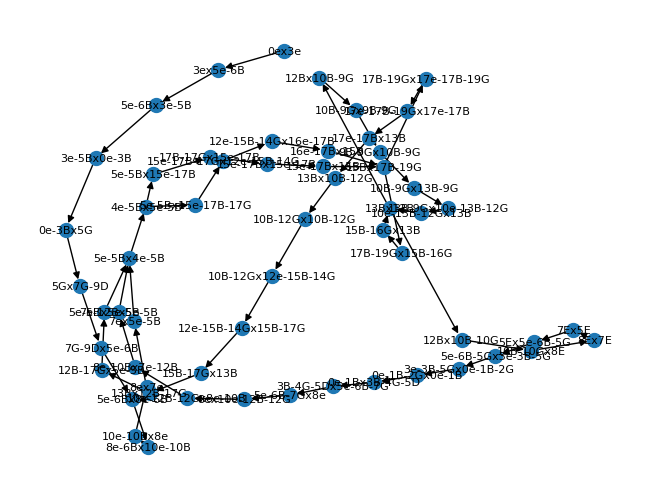

In [16]:
nx.draw(LdG, with_labels=True, node_size=100, font_size=8)

### Second order memory

In [18]:
def line_second_datagraph(song, silence=True, track=None):
    '''
    Construct the subgraph of the linegraph of the Markov chain, 
    dictated by the existence of the connections between edges in the data.
    '''
    
    L2dG = nx.DiGraph()
    
    # Populate the graph without silences
    nodelist, key, frac = get_nodes(song)
    L2dG.key = key
    L2dG.frac = frac
    
    # Create the nodes of the Linegraph, i.e. the edges of the graph.
    edgelist = []
    for nodei, nodem, nodef in zip(nodelist[:-2],nodelist[1:-1], nodelist[2:]):
        if nodei and nodem and nodef:
            edgelist.append(nodei + 'x' + nodem + 'x' + nodef)
    
    # Connect the contiguous edges from the data
    for i, edge in enumerate(edgelist[:-1]):
        if (edge, edgelist[i+1]) in L2dG.edges:
            L2dG.edges[edge, edgelist[i+1]]['weight'] += 1
        else:
            L2dG.add_edge(edge, edgelist[i+1], weight=1)

    # Normalize the out-edge weights
    for node, degree in dict(L2dG.out_degree()).items():
        
        sum_weights = np.sum([L2dG.edges[edge[0], edge[1]]['weight'] for edge in L2dG.out_edges(node)])
        
        for edge in L2dG.out_edges(node):
            L2dG.edges[edge[0], edge[1]]['weight'] /= sum_weights
            
    return L2dG
    

In [19]:
L2dG = line_second_datagraph(song, silence=True, track=None)

Traccia 1
Measure key: CMajor
Measure time signature: 3/4


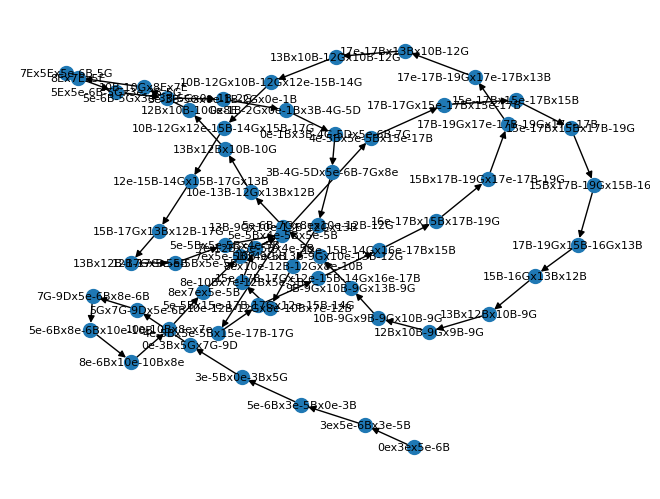

In [20]:
nx.draw(L2dG, with_labels=True, node_size=100, font_size=8)

### Failed attempt corner

In [11]:
def construct_chain_withmemory(song, silence=True, track=None, alpha=0.5):
    '''
    First order Markov memory.
    With alpha probability it follows standard Markov, 
    with 1-alpha it follows the first order memory graph M.
    '''
    G = nx.DiGraph()
    M = nx.DiGraph()
    
    # Populate the graph without silences
    nodelist, key, frac = get_nodes(song)
    G.key = key
    G.frac = frac
    for node in nodelist:
        if node:
            G.add_node(node)
            M.add_node(node)
            
    ### MARKOVIAN GRAPH ###
    
    # Connect the notes in G to the subsequent note
    for edge in zip(nodelist[:-1], nodelist[1:]):
        
        if not edge[0] or not edge[1]:
            continue
        
        if edge in G.edges:
            G.edges[edge[0], edge[1]]['weight'] += 1
        else:
            G.add_edge(*edge, weight=1)
    
    # Normalize the out-edge weights
    for node, degree in dict(G.out_degree()).items():
        
        sum_weights = np.sum([G.edges[edge[0], edge[1]]['weight'] for edge in G.out_edges(node)])
        
        for edge in G.out_edges(node):
            G.edges[edge[0], edge[1]]['weight'] /= sum_weights
            
    ### MEMORY GRAPH ###
    
    # Connect the notes in M to the subsubsequent note
    for i, basenode in enumerate(nodelist[:-2]):
        
        edge = (basenode, nodelist[i+2])
        
        if not edge[0] or not edge[1]:
            continue
        
        if edge in M.edges:
            M.edges[edge[0], edge[1]]['weight'] += 1
        else:
            M.add_edge(*edge, weight=1, in_between=nodelist[i+1])
    
    # Same for the Memory graph
    for node, degree in dict(M.out_degree()).items():
        
        sum_weights = np.sum([M.edges[edge[0], edge[1]]['weight'] for edge in M.out_edges(node)])
        
        for edge in M.out_edges(node):
            M.edges[edge[0], edge[1]]['weight'] /= sum_weights
    
    return G, M

Traccia 1
Measure key: CMajor
Measure time signature: 3/4


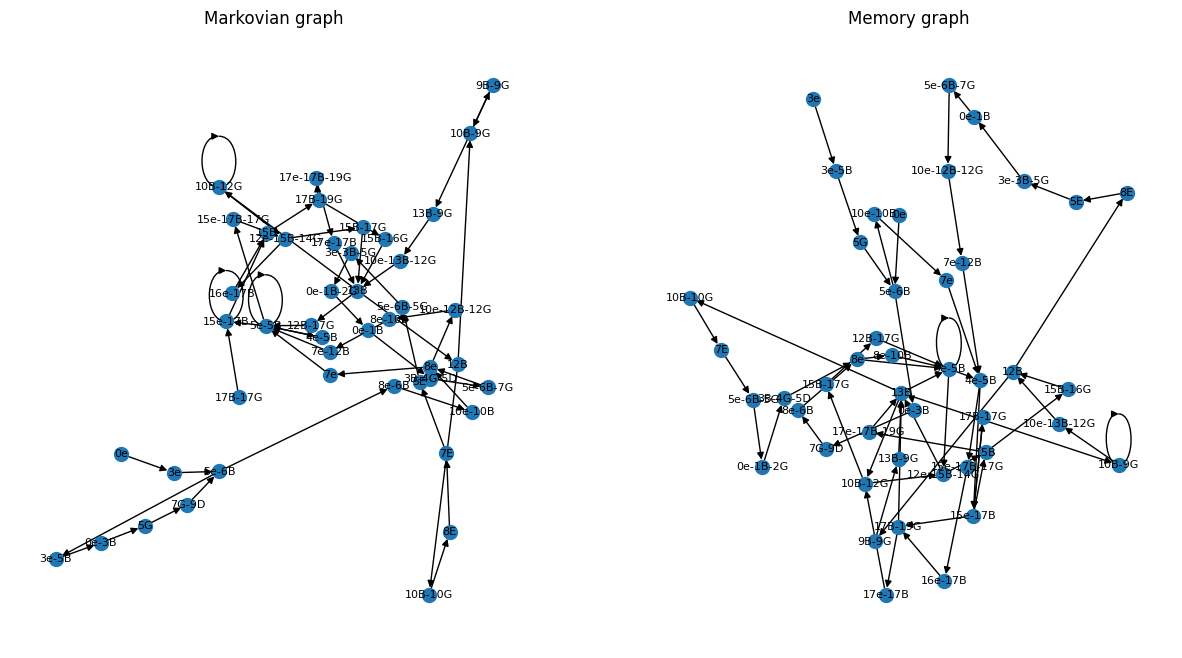

In [12]:
G, M = construct_chain_withmemory(song)
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].set_title('Markovian graph')
ax[1].set_title('Memory graph')
nx.draw(G, ax=ax[0], with_labels = True, node_size=100, font_size=8)
nx.draw(M, ax=ax[1], with_labels = True, node_size=100, font_size=8)

In [13]:
M.edges(data=True)

OutEdgeDataView([('0e', '5e-6B', {'weight': 1.0, 'in_between': '3e'}), ('3e', '3e-5B', {'weight': 1.0, 'in_between': '5e-6B'}), ('5e-6B', '0e-3B', {'weight': 0.5, 'in_between': '3e-5B'}), ('5e-6B', '10e-10B', {'weight': 0.5, 'in_between': '8e-6B'}), ('3e-5B', '5G', {'weight': 1.0, 'in_between': '0e-3B'}), ('0e-3B', '7G-9D', {'weight': 1.0, 'in_between': '5G'}), ('5G', '5e-6B', {'weight': 1.0, 'in_between': '7G-9D'}), ('7G-9D', '8e-6B', {'weight': 1.0, 'in_between': '5e-6B'}), ('8e-6B', '8e', {'weight': 1.0, 'in_between': '10e-10B'}), ('10e-10B', '7e', {'weight': 1.0, 'in_between': '8e'}), ('8e', '5e-5B', {'weight': 0.5, 'in_between': '7e'}), ('8e', '8e-10B', {'weight': 0.5, 'in_between': '10e-12B-12G'}), ('7e', '4e-5B', {'weight': 1.0, 'in_between': '5e-5B'}), ('5e-5B', '5e-5B', {'weight': 0.6, 'in_between': '4e-5B'}), ('5e-5B', '12e-15B-14G', {'weight': 0.2, 'in_between': '15e-17B-17G'}), ('5e-5B', '4e-5B', {'weight': 0.2, 'in_between': '5e-5B'}), ('4e-5B', '15e-17B', {'weight': 0.5, 